In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sms
%matplotlib inline

In [2]:
df=pd.read_csv("air passangers.csv",index_col=0)

In [3]:
df.head()

,Month,Thousands of Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [4]:
df.shape

(145, 2)

In [5]:
df.isnull().sum()

Month                      0
Thousands of Passengers    1
dtype: int64

In [6]:
df.dropna(axis=0,inplace= True)

In [7]:
df.shape

(144, 2)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    144 non-null    object 
 1   Thousands of Passengers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.4+ KB


In [9]:
df["Month"]=pd.to_datetime(df["Month"],)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Month                    144 non-null    datetime64[ns]
 1   Thousands of Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.4 KB


In [11]:
df.head()

,Month,Thousands of Passengers
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


In [12]:
#set month column as index
df.set_index('Month',inplace=True)

In [13]:
df.head()

,Thousands of Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


<AxesSubplot: xlabel='Month'>

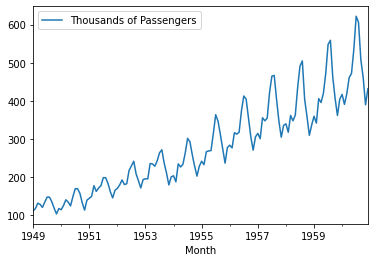

In [14]:
df.plot()

 **<u> from the plot, it seems that the data is seasonal and has +ve trend.
so, data is non-stationary.</u>**

### Preprocessing of time series data

In [15]:
from statsmodels.tsa.stattools import adfuller

In [16]:
def adf_fuller(series):
    result=adfuller(series)      #dickey fuller test
    print(f"adf test statistic : {result[0]}")
    print(f"p-value : {result[1]}")
    if result[1]<=0.05:
        print("--rejecting null hypothesis indicating time series data has no unit root and is stationary.")
    else:
        print("--accepting null hypothesis indicating time series has a unit root and data is non-stationary.")
    

In [17]:
adf_fuller(df["Thousands of Passengers"])

adf test statistic : 0.8153688792060411
p-value : 0.9918802434376409
--accepting null hypothesis indicating time series has a unit root and data is non-stationary.


As we know, data is not stationary, therefore in order to make data stationary, we need to differencing.(shift the data by 1,2,3...until data reaches to stationary.)

In [18]:
# differencing 
df["1st differenece passengers"]=df["Thousands of Passengers"]-df["Thousands of Passengers"].shift(1)

In [19]:
df.head()

,Thousands of Passengers,1st differenece passengers
Month,,
1949-01-01,112.0,NaN
1949-02-01,118.0,6.0
1949-03-01,132.0,14.0
1949-04-01,129.0,-3.0
1949-05-01,121.0,-8.0


In [20]:
adf_fuller(df["1st differenece passengers"].dropna())

adf test statistic : -2.8292668241699945
p-value : 0.05421329028382621
--accepting null hypothesis indicating time series has a unit root and data is non-stationary.


In [21]:
# differencing 
df["2nd differenece passengers"]=df["1st differenece passengers"]-df["1st differenece passengers"].shift(1)

In [22]:
adf_fuller(df["2nd differenece passengers"].dropna())

adf test statistic : -16.384231542468466
p-value : 2.732891850014397e-29
--rejecting null hypothesis indicating time series data has no unit root and is stationary.


In [23]:
# since data is seasonal, therefore also checking stationarity at 12 months.
#  since, SARIMAX is better than ARIMA in seasonal data .
df["12th differenece passengers"]=df["Thousands of Passengers"]-df["Thousands of Passengers"].shift(12)

In [24]:
adf_fuller(df["12th differenece passengers"].dropna())

adf test statistic : -3.3830207264924814
p-value : 0.011551493085514954
--rejecting null hypothesis indicating time series data has no unit root and is stationary.


<AxesSubplot: xlabel='Month'>

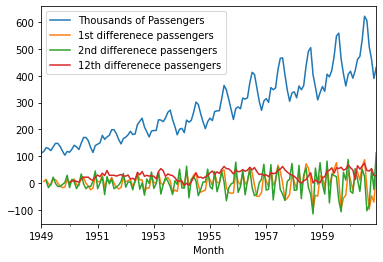

In [25]:
df.plot()

In [26]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

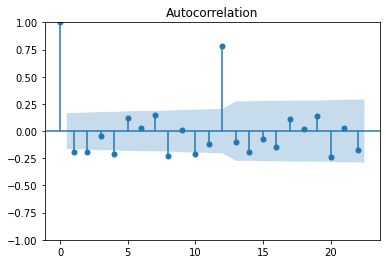

In [27]:
acf2=plot_acf(df["2nd differenece passengers"].dropna())

Here, we can see seasonality.

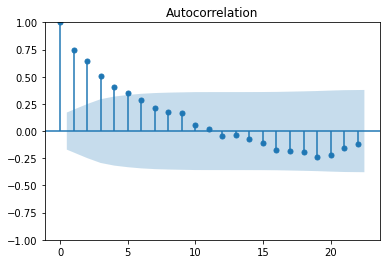

In [28]:
acf12=plot_acf(df["12th differenece passengers"].dropna())

q=5

C:\Users\tp220\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


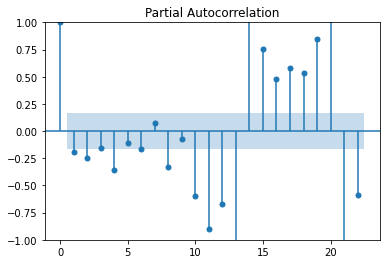

In [29]:
pacf2=plot_pacf(df["2nd differenece passengers"].dropna())

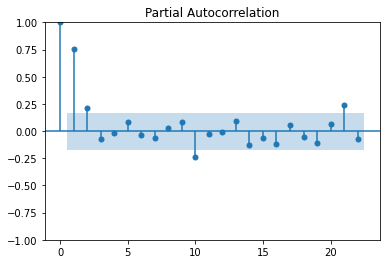

In [30]:
pacf12=plot_pacf(df["12th differenece passengers"].dropna())

p=2, p=10   ,check with both

acf value (q) for MA and pacf value(p) FOR AR  and d is differenicing value (integration)

### Train test split

In [31]:
from datetime import datetime,timedelta
train_data_end=datetime(1955,12,1)
test_data_end=datetime(1960,12,1)

In [32]:
train_data=df[:train_data_end]
test_data=df[train_data_end+timedelta(days=1):test_data_end]

In [33]:
# prediction
pred_start_date=test_data.index[0]
pred_end_date=test_data.index[-1]

In [34]:
test_data

,Thousands of Passengers,1st differenece passengers,2nd differenece passengers,12th differenece passengers
Month,,,,
1956-01-01,284.0,6.0,-35.0,42.0
1956-02-01,277.0,-7.0,-13.0,44.0
1956-03-01,317.0,40.0,47.0,50.0
1956-04-01,313.0,-4.0,-44.0,44.0
1956-05-01,318.0,5.0,9.0,48.0
1956-06-01,374.0,56.0,51.0,59.0
1956-07-01,413.0,39.0,-17.0,49.0
1956-08-01,405.0,-8.0,-47.0,58.0
1956-09-01,355.0,-50.0,-42.0,43.0


In [35]:
from statsmodels.tsa.arima.model import ARIMA

In [36]:
train_data

,Thousands of Passengers,1st differenece passengers,2nd differenece passengers,12th differenece passengers
Month,,,,
1949-01-01,112.0,NaN,NaN,NaN
1949-02-01,118.0,6.0,NaN,NaN
1949-03-01,132.0,14.0,8.0,NaN
1949-04-01,129.0,-3.0,-17.0,NaN
1949-05-01,121.0,-8.0,-5.0,NaN
...,...,...,...,...
1955-08-01,347.0,-17.0,-66.0,54.0
1955-09-01,312.0,-35.0,-18.0,53.0
1955-10-01,274.0,-38.0,-3.0,45.0


### Building model ARIMA

In [68]:
model_ARIMA=ARIMA(train_data['Thousands of Passengers'],order=(10,2,12))

C:\Users\tp220\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\tp220\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\tp220\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [69]:
model_arima_fit=model_ARIMA.fit()

C:\Users\tp220\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tp220\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [70]:
model_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:     Thousands of Passengers   No. Observations:                   84
Model:                    ARIMA(10, 2, 12)   Log Likelihood                -307.735
Date:                     Sun, 12 Feb 2023   AIC                            661.470
Time:                             15:37:35   BIC                            716.824
Sample:                         01-01-1949   HQIC                           683.694
                              - 12-01-1955                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0468      0.115      0.408      0.683      -0.178       0.271
ar.L2         -1.0428      0.084    -12.479      0.000      -1.207      -0.879
ar.L3          0.0886      0.139      0.638      0.523      -0.183       0.361
ar.L4         -1.0258      0.131     -7.826      0.000      -1.283      -0.769
ar.L5          0.0658      0.155      0.423      0.672      -0.239       0.370
ar.L6         -0.9861      0.143     -6.882      0.000      -1.267      -0.705
ar.L7          0.0175      0.142      0.123      0.902      -0.261       0.296
ar.L8         -0.9822      0.122     -8.029      0.000      -1.222      -0.742
ar.L9         -0.0069      0.095     -0.073      0.942      -0.193       0.179
ar.L10        -0.9389      0.085    -11.095      0.000      -1.105      -0.773
ma.L1         -1.2855      0.254     -5.057      0.000      -1.784      -0.787
ma.L2          1.2393      0.359      3.455      0.001       0.536       1.942
ma.L3         -1.4414      0.437     -3.302      0.001      -2.297      -0.586
ma.L4          1.3761      0.507      2.713      0.007       0.382       2.370
ma.L5         -1.2166      0.575     -2.116      0.034      -2.343      -0.090
ma.L6          1.0831      0.660      1.640      0.101      -0.211       2.378
ma.L7         -1.0701      0.715     -1.497      0.134      -2.471       0.331
ma.L8          0.8860      0.819      1.082      0.279      -0.719       2.491
ma.L9         -0.7851      0.737     -1.066      0.287      -2.229       0.659
ma.L10         0.5230      0.601      0.870      0.385      -0.656       1.702
ma.L11        -0.4130      0.455     -0.908      0.364      -1.305       0.479
ma.L12         0.1336      0.273      0.489      0.625      -0.402       0.669
sigma2        77.2668     16.217      4.765      0.000      45.482     109.052
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 4.74
Prob(Q):                              0.99   Prob(JB):                         0.09
Heteroskedasticity (H):               2.12   Skew:                             0.59
Prob(H) (two-sided):                  0.06   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [71]:
## prediction
pred_start_date=test_data.index[0]
pred_end_date=test_data.index[-1]
print(pred_start_date,"\n",pred_end_date)

1956-01-01 00:00:00 
 1960-12-01 00:00:00


In [72]:
pred=model_arima_fit.predict(start=pred_start_date, end=pred_end_date)
residuals=test_data["Thousands of Passengers"]-pred

In [73]:
pred

1956-01-01    283.242873
1956-02-01    269.514103
1956-03-01    295.183068
1956-04-01    298.588681
1956-05-01    299.100478
1956-06-01    345.356101
1956-07-01    388.482741
1956-08-01    371.890016
1956-09-01    340.092040
1956-10-01    302.900027
1956-11-01    271.802394
1956-12-01    302.626782
1957-01-01    311.075567
1957-02-01    293.800687
1957-03-01    316.959630
1957-04-01    324.515000
1957-05-01    326.103582
1957-06-01    372.702962
1957-07-01    414.550261
1957-08-01    396.551830
1957-09-01    365.299494
1957-10-01    332.225614
1957-11-01    302.504951
1957-12-01    329.456074
1958-01-01    338.538159
1958-02-01    318.388093
1958-03-01    338.947929
1958-04-01    350.515720
1958-05-01    353.232374
1958-06-01    399.575648
1958-07-01    440.481828
1958-08-01    421.293814
1958-09-01    390.675874
1958-10-01    361.579929
1958-11-01    333.162860
1958-12-01    356.289890
1959-01-01    365.685065
1959-02-01    343.247274
1959-03-01    361.179876
1959-04-01    376.550878


In [74]:
residuals

Month
1956-01-01      0.757127
1956-02-01      7.485897
1956-03-01     21.816932
1956-04-01     14.411319
1956-05-01     18.899522
1956-06-01     28.643899
1956-07-01     24.517259
1956-08-01     33.109984
1956-09-01     14.907960
1956-10-01      3.099973
1956-11-01     -0.802394
1956-12-01      3.373218
1957-01-01      3.924433
1957-02-01      7.199313
1957-03-01     39.040370
1957-04-01     23.485000
1957-05-01     28.896418
1957-06-01     49.297038
1957-07-01     50.449739
1957-08-01     70.448170
1957-09-01     38.700506
1957-10-01     14.774386
1957-11-01      2.495049
1957-12-01      6.543926
1958-01-01      1.461841
1958-02-01     -0.388093
1958-03-01     23.052071
1958-04-01     -2.515720
1958-05-01      9.767626
1958-06-01     35.424352
1958-07-01     50.518172
1958-08-01     83.706186
1958-09-01     13.324126
1958-10-01     -2.579929
1958-11-01    -23.162860
1958-12-01    -19.289890
1959-01-01     -5.685065
1959-02-01     -1.247274
1959-03-01     44.820124
1959-04-01     19.4

<AxesSubplot: ylabel='Density'>

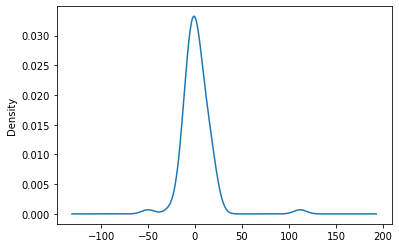

In [75]:
model_arima_fit.resid.plot(kind='kde')

In [76]:
test_data["Predicted_ARIMA"]=pred

C:\Users\tp220\AppData\Local\Temp\ipykernel_67580\4223836109.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["Predicted_ARIMA"]=pred


<AxesSubplot: xlabel='Month'>

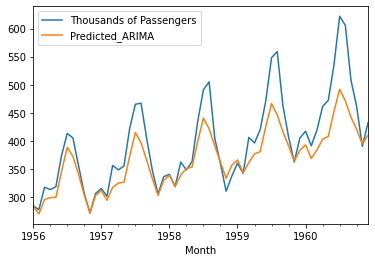

In [77]:
test_data[['Thousands of Passengers','Predicted_ARIMA']].plot()

In [78]:
### SARIMAX Model

In [79]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [99]:
model_sarima=SARIMAX(train_data['Thousands of Passengers'],order=(3,0,5),seasonal_order=(0,1,0,12))

C:\Users\tp220\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\tp220\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [100]:
model_sarima_fit=model_sarima.fit()

C:\Users\tp220\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [101]:
model_sarima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:             Thousands of Passengers   No. Observations:                   84
Model:             SARIMAX(3, 0, 5)x(0, 1, [], 12)   Log Likelihood                -265.241
Date:                             Sun, 12 Feb 2023   AIC                            548.481
Time:                                     15:38:51   BIC                            568.971
Sample:                                 01-01-1949   HQIC                           556.638
                                      - 12-01-1955                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5995      0.939      0.639      0.523      -1.240       2.439
ar.L2          0.8314      0.232      3.577      0.000       0.376       1.287
ar.L3         -0.4539      0.895     -0.507      0.612      -2.208       1.300
ma.L1          0.1825      1.169      0.156      0.876      -2.109       2.474
ma.L2         -0.5355      1.267     -0.422      0.673      -3.020       1.949
ma.L3         -0.0985      0.386     -0.255      0.798      -0.855       0.658
ma.L4         -0.1270      0.339     -0.375      0.708      -0.791       0.537
ma.L5          0.2472      0.358      0.691      0.490      -0.454       0.948
sigma2        87.7168     81.578      1.075      0.282     -72.173     247.607
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 2.68
Prob(Q):                              0.88   Prob(JB):                         0.26
Heteroskedasticity (H):               2.05   Skew:                             0.46
Prob(H) (two-sided):                  0.09   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [102]:
pred=model_sarima_fit.predict(start=pred_start_date, end=pred_end_date)
residuals=test_data["Thousands of Passengers"]-pred

In [103]:
pred

1956-01-01    286.191274
1956-02-01    281.281153
1956-03-01    309.923355
1956-04-01    310.684202
1956-05-01    311.338679
1956-06-01    354.955206
1956-07-01    403.400977
1956-08-01    385.075366
1956-09-01    349.447826
1956-10-01    310.221102
1956-11-01    272.565637
1956-12-01    312.437659
1957-01-01    319.964567
1957-02-01    314.015901
1957-03-01    341.995134
1957-04-01    341.796664
1957-05-01    341.796239
1957-06-01    384.523519
1957-07-01    432.327140
1957-08-01    413.174521
1957-09-01    376.920942
1957-10-01    336.922821
1957-11-01    298.659801
1957-12-01    337.810430
1958-01-01    344.749886
1958-02-01    338.125060
1958-03-01    365.537975
1958-04-01    364.704496
1958-05-01    364.159463
1958-06-01    406.289367
1958-07-01    453.570314
1958-08-01    433.854901
1958-09-01    397.100531
1958-10-01    356.571534
1958-11-01    317.829355
1958-12-01    356.478675
1959-01-01    362.960196
1959-02-01    355.861549
1959-03-01    382.837233
1959-04-01    381.555563


In [104]:
residuals


Month
1956-01-01     -2.191274
1956-02-01     -4.281153
1956-03-01      7.076645
1956-04-01      2.315798
1956-05-01      6.661321
1956-06-01     19.044794
1956-07-01      9.599023
1956-08-01     19.924634
1956-09-01      5.552174
1956-10-01     -4.221102
1956-11-01     -1.565637
1956-12-01     -6.437659
1957-01-01     -4.964567
1957-02-01    -13.015901
1957-03-01     14.004866
1957-04-01      6.203336
1957-05-01     13.203761
1957-06-01     37.476481
1957-07-01     32.672860
1957-08-01     53.825479
1957-09-01     27.079058
1957-10-01     10.077179
1957-11-01      6.340199
1957-12-01     -1.810430
1958-01-01     -4.749886
1958-02-01    -20.125060
1958-03-01     -3.537975
1958-04-01    -16.704496
1958-05-01     -1.159463
1958-06-01     28.710633
1958-07-01     37.429686
1958-08-01     71.145099
1958-09-01      6.899469
1958-10-01      2.428466
1958-11-01     -7.829355
1958-12-01    -19.478675
1959-01-01     -2.960196
1959-02-01    -13.861549
1959-03-01     23.162767
1959-04-01     14.4

<AxesSubplot: ylabel='Density'>

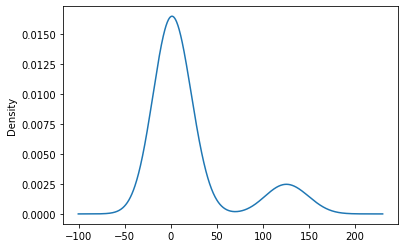

In [105]:
model_sarima_fit.resid.plot(kind='kde')

In [106]:
test_data["Predicted_SARIMA"]=pred

C:\Users\tp220\AppData\Local\Temp\ipykernel_67580\269689088.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["Predicted_SARIMA"]=pred


<AxesSubplot: xlabel='Month'>

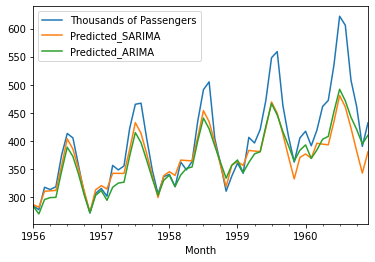

In [107]:
test_data[['Thousands of Passengers','Predicted_SARIMA','Predicted_ARIMA']].plot()

here, we can see Sarima working slightly better than arima in seasonal data

#### prediction made on some new data using model_sarima_fit

In [110]:
model_sarima_fit.predict(start="1989,01,01",end="1993,01,01")

1989-01-01    413.502806
1989-02-01    405.120408
1989-03-01    430.853710
1989-04-01    428.353148
1989-05-01    426.210057
1989-06-01    466.758318
1989-07-01    512.519159
1989-08-01    491.302849
1989-09-01    453.102809
1989-10-01    411.149288
1989-11-01    371.032458
1989-12-01    408.329539
1990-01-01    413.504122
1990-02-01    405.121690
1990-03-01    430.854960
1990-04-01    428.354366
1990-05-01    426.211244
1990-06-01    466.759475
1990-07-01    512.520287
1990-08-01    491.303948
1990-09-01    453.103881
1990-10-01    411.150332
1990-11-01    371.033476
1990-12-01    408.330531
1991-01-01    413.505089
1991-02-01    405.122633
1991-03-01    430.855879
1991-04-01    428.355261
1991-05-01    426.212117
1991-06-01    466.760326
1991-07-01    512.521116
1991-08-01    491.304757
1991-09-01    453.104669
1991-10-01    411.151100
1991-11-01    371.034224
1991-12-01    408.331260
1992-01-01    413.505800
1992-02-01    405.123326
1992-03-01    430.856554
1992-04-01    428.355919
